In [932]:
import pandas as pd
import numpy as np
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

PATH = os.path.join("datasets", "ps4")

def load_region_data(data_path=PATH):
    os.makedirs(data_path, exist_ok=True)
    csv_path = os.path.join(data_path, "chirper-happiness.csv")
    return pd.read_csv(csv_path)

In [933]:
# Load csv file and investigate the data
regions = load_region_data()
regions.head()

,Id2,totalGroup1,totalGroup2,percent_bachelorPlus,meanvalence,households_meanIncome
0,6037101110,1244,2319,19.4,5.863903,68938
1,6037101122,304,2175,27.2,5.963174,120490
2,6037101210,2434,2078,16.6,5.623312,54481
3,6037101220,509,1370,19.8,5.687386,51880
4,6037101300,365,3116,31.0,5.687331,90933


In [934]:
regions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2110 entries, 0 to 2109
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id2                    2110 non-null   int64  
 1   totalGroup1            2110 non-null   int64  
 2   totalGroup2            2110 non-null   int64  
 3   percent_bachelorPlus   2110 non-null   float64
 4   meanvalence            2110 non-null   float64
 5   households_meanIncome  2110 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 99.0 KB


In [935]:
# Remove outliers from data to ensure better predictions
regions.drop(regions[(regions.totalGroup2 > 5500)].index , inplace=True)
regions.drop(regions[(regions.meanvalence > 6.4) | (regions.meanvalence < 5.3)].index , inplace=True)
regions.drop(regions[(regions.households_meanIncome > 305000) | (regions.households_meanIncome < 20000)].index , inplace=True)

In [936]:
# Remove extranneous feature id
regions = regions.drop(["Id2"], axis=1)
regions.head()

,totalGroup1,totalGroup2,percent_bachelorPlus,meanvalence,households_meanIncome
0,1244,2319,19.4,5.863903,68938
1,304,2175,27.2,5.963174,120490
2,2434,2078,16.6,5.623312,54481
3,509,1370,19.8,5.687386,51880
4,365,3116,31.0,5.687331,90933


In [937]:
# Pipeline to standardize valence data
result_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

ground_truth_scaled = result_pipeline.fit_transform(regions['meanvalence'].to_frame())

In [938]:
# Convert to 1-D
ground_truth_scaled = ground_truth_scaled.flatten()
ground_truth_scaled = pd.Series(ground_truth_scaled)

In [939]:
mean = regions['meanvalence'].mean()
std = regions['meanvalence'].std()
benchmark = (5.8 - mean)/std
print("Benchmark of 5.8 standardized:", benchmark)

Benchmark of 5.8 standardized: -0.2551326208101596


Correlation grouped by which group an area had more people of:
category                       
b         households_meanIncome    0.204225
r         households_meanIncome    0.126912
Name: meanvalence, dtype: float64

 category                      
b         percent_bachelorPlus    0.394011
r         percent_bachelorPlus    0.314063
Name: meanvalence, dtype: float64 

Overall correlation:
 totalGroup1             -0.368542
totalGroup2              0.345127
percent_bachelorPlus     0.474566
meanvalence              1.000000
households_meanIncome    0.332390
Name: meanvalence, dtype: float64


Text(0, 0.5, 'Mean Valence')

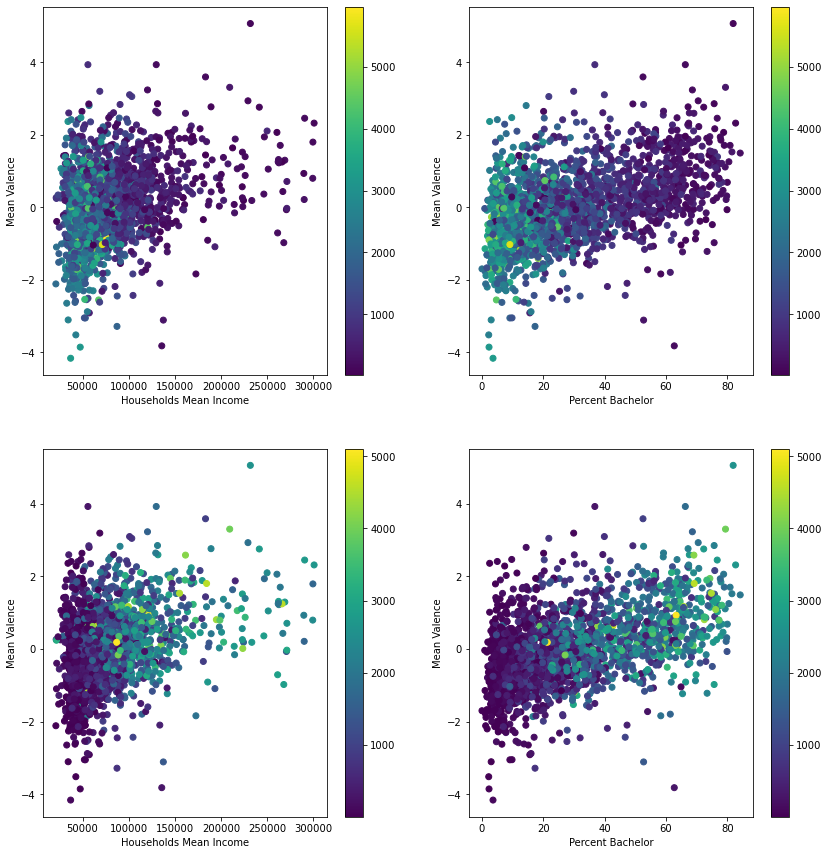

In [940]:
import matplotlib.pyplot as plt

# Variable to show correlation by group--determine groups by whether group 1 or 2 has more individuals in the region
col = np.where(regions['totalGroup1'] < regions['totalGroup2'],'b', 'r')
regions['category'] = col

fig = plt.figure(figsize=(14,6))
fig.subplots_adjust(top=2)
ax1 = fig.add_subplot(221)

# Scatter plot and correlation of ground truth valence vs mean household income 
plot1 = ax1.scatter(regions['households_meanIncome'], ground_truth_scaled, c=regions['totalGroup1'])
plt.colorbar(plot1, ax=ax1)
ax1.set_xlabel('Households Mean Income')
ax1.set_ylabel('Mean Valence')
print("Correlation grouped by which group an area had more people of:")
print(regions.groupby('category')[['households_meanIncome','meanvalence']].corr().iloc[0::2,-1])

ax2 = fig.add_subplot(222)

# Scatter plot and correlation of ground truth valence vs number of those with at least a bachelor's
plot2 = ax2.scatter(regions['percent_bachelorPlus'], ground_truth_scaled, c=regions['totalGroup1'])
plt.colorbar(plot2, ax=ax2)
ax2.set_xlabel('Percent Bachelor')
ax2.set_ylabel('Mean Valence')
print('\n', regions.groupby('category')[['percent_bachelorPlus','meanvalence']].corr().iloc[0::2,-1], '\n')
print('Overall correlation:\n', regions.corr().iloc[0::1,-2])

ax3 = fig.add_subplot(223)

# Scatter plot and correlation of ground truth valence vs mean household income 
plot3 = ax3.scatter(regions['households_meanIncome'], ground_truth_scaled, c=regions['totalGroup2'])
plt.colorbar(plot3, ax=ax3)
ax3.set_xlabel('Households Mean Income')
ax3.set_ylabel('Mean Valence')

ax4 = fig.add_subplot(224)

# Scatter plot and correlation of ground truth valence vs mean household income 
plot4 = ax4.scatter(regions['percent_bachelorPlus'], ground_truth_scaled, c=regions['totalGroup2'])
plt.colorbar(plot4, ax=ax4)
ax4.set_xlabel('Percent Bachelor')
ax4.set_ylabel('Mean Valence')


In [941]:
regions = regions.drop(["category"], axis=1)

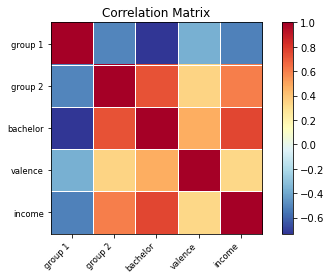

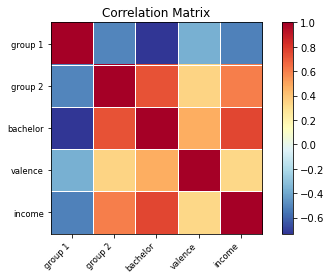

In [942]:
import statsmodels.graphics.api as smg

# Plot to show the opposite correlations between each group and the variables
smg.plot_corr(regions.corr(), xnames=['group 1', 'group 2', 'bachelor', 'valence', 'income'], ynames=['group 1', 'group 2', 'bachelor', 'valence', 'income'])

In [943]:
from sklearn.model_selection import train_test_split

# Start the first model by training 80% of the data as race aware
train_set, test_set = train_test_split(regions, test_size=0.2, random_state=42)

In [944]:
regions_train_copy = train_set.copy()

In [945]:
# Set variables for testing in the future
regions_train_copy = regions_train_copy.drop("meanvalence", axis=1)
regions_labels = train_set["meanvalence"].copy()
regions_test_y = test_set["meanvalence"].copy()

In [946]:
# Normalize all numerical values to ensure equal weight in prediction
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

regions_prepared = num_pipeline.fit_transform(regions_train_copy)

In [947]:
result_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

regions_labels = result_pipeline.fit_transform(regions_labels.to_frame())

In [948]:
regions_labels = regions_labels.flatten()
regions_labels = pd.Series(regions_labels)

In [949]:
from sklearn.linear_model import LinearRegression

# Run the regression on prepared data and expected labels
lin_reg = LinearRegression()
lin_reg.fit(regions_prepared, regions_labels)

LinearRegression()

In [950]:
# Check to briefly see accuracy of predictions
all_data_prepared = num_pipeline.transform(regions.drop(['meanvalence'], axis=1))
predictions = lin_reg.predict(all_data_prepared)

print("Predictions:", predictions)

print("Labels:", regions['meanvalence'])

Predictions: [-0.21181072 -0.08275946 -0.27812326 ...  0.9258458  -0.00398355
 -0.31094558]
Labels: 0       5.863903
1       5.963174
2       5.623312
3       5.687386
4       5.687331
          ...   
2105    5.877809
2106    5.888279
2107    5.713390
2108    5.820676
2109    5.811784
Name: meanvalence, Length: 2097, dtype: float64


Correlation grouped by which group an area had more people of:
category        
b         income    0.443920
r         income    0.514735
Name: predictions, dtype: float64

 category          
b         bachelor    0.987462
r         bachelor    0.994911
Name: predictions, dtype: float64 

Overall correlation:
 income         0.707694
bachelor       0.996404
predictions    1.000000
Name: predictions, dtype: float64


Text(0, 0.5, 'Mean Valence')

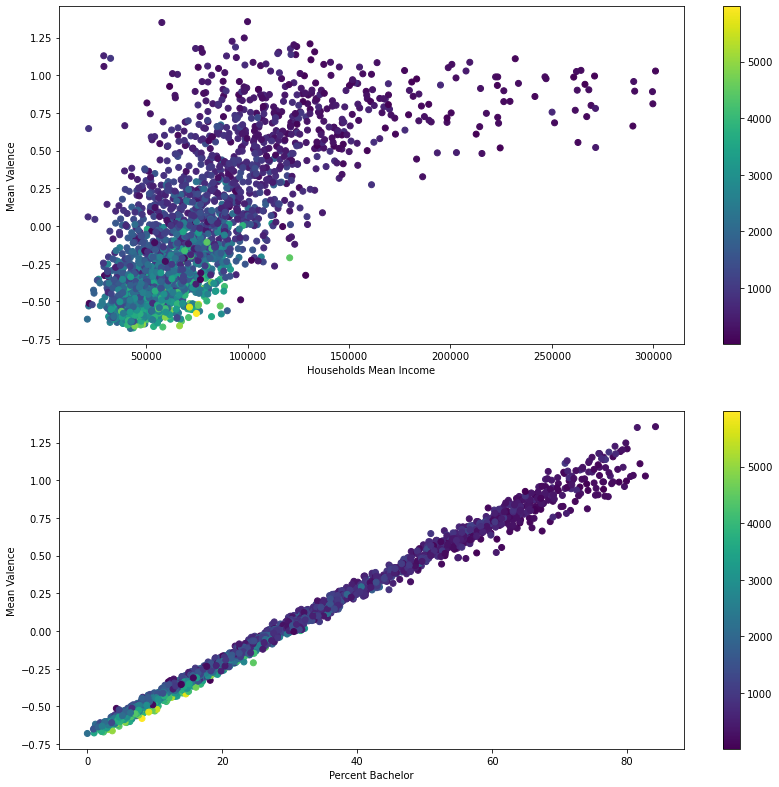

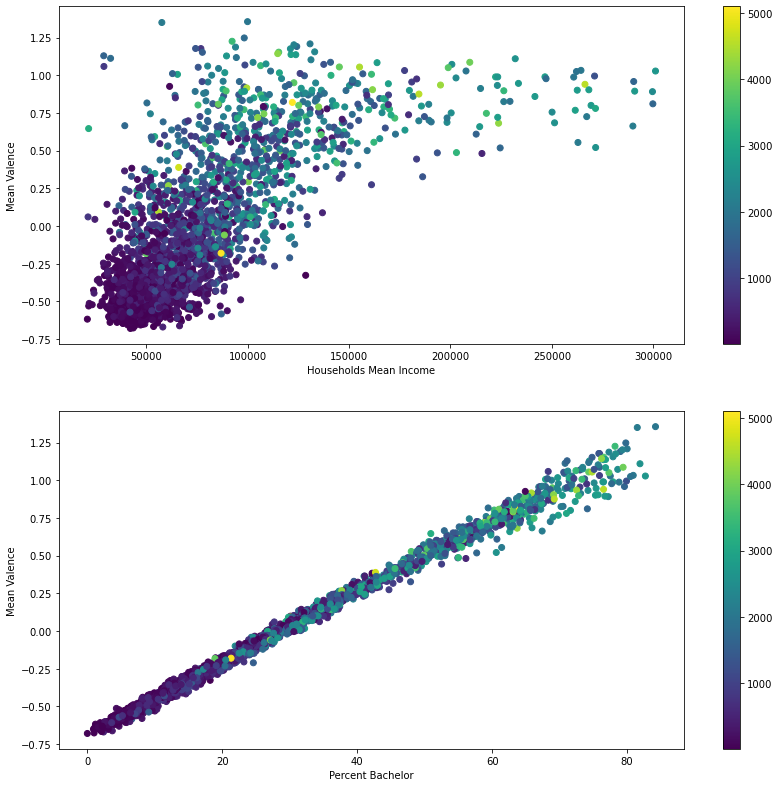

In [951]:
col = np.where(regions['totalGroup1'] < regions['totalGroup2'],'b', 'r')
regions['category'] = col

# Create dataframe in order to show separated correlations as well as overall
frame = {"category": col, "income": regions['households_meanIncome'], "bachelor": regions['percent_bachelorPlus'], "predictions": predictions }
df = pd.DataFrame(frame)

fig = plt.figure(figsize=(14,5.5))
fig.subplots_adjust(top=2)
ax1 = fig.add_subplot(211)

# Scatter plot and correlation of predicted valences and mean household incomes
plot1 = ax1.scatter(regions['households_meanIncome'], predictions, c=regions['totalGroup1'])
plt.colorbar(plot1, ax=ax1)
ax1.set_xlabel('Households Mean Income')
ax1.set_ylabel('Mean Valence')
print("Correlation grouped by which group an area had more people of:")
print(df.groupby('category')[['income','predictions']].corr().iloc[0::2,-1])

ax2 = fig.add_subplot(212)

# Scatter plot and correlation of predicted valences and number of those with at least a bachelor's
# It can be seen predicted valence is much lower than ground truth valence and mainly below 5.8 for group 1
plot2 = ax2.scatter(regions['percent_bachelorPlus'], predictions, c=regions['totalGroup1'])
plt.colorbar(plot2, ax=ax2)
ax2.set_xlabel('Percent Bachelor')
ax2.set_ylabel('Mean Valence')
print('\n',df.groupby('category')[['bachelor','predictions']].corr().iloc[0::2,-1], '\n')
print('Overall correlation:\n', df.corr().iloc[0::1,-1])

fig2 = plt.figure(figsize=(14,5.5))
fig2.subplots_adjust(top=2)

ax3 = fig2.add_subplot(211)

# Scatter plot and correlation of ground truth valence vs mean household income 
plot3 = ax3.scatter(regions['households_meanIncome'], predictions, c=regions['totalGroup2'])
plt.colorbar(plot3, ax=ax3)
ax3.set_xlabel('Households Mean Income')
ax3.set_ylabel('Mean Valence')

ax4 = fig2.add_subplot(212)

# Scatter plot and correlation of ground truth valence vs mean household income 
plot4 = ax4.scatter(regions['percent_bachelorPlus'], predictions, c=regions['totalGroup2'])
plt.colorbar(plot4, ax=ax4)
ax4.set_xlabel('Percent Bachelor')
ax4.set_ylabel('Mean Valence')

In [952]:
regions = regions.drop(["category"], axis=1)

In [953]:
# Start new training of race blind model
train_set, test_set = train_test_split(regions, test_size=0.2, random_state=42)

In [954]:
regions_train_copy = train_set.copy()

In [955]:
# Ensure model is race blind and remove the features
regions_train_copy = regions_train_copy.drop(["meanvalence", "totalGroup1", "totalGroup2"], axis=1)

regions_labels = train_set["meanvalence"].copy()
regions_test_y = test_set["meanvalence"].copy()

In [956]:
# Transform data for equal influence
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

regions_prepared = num_pipeline.fit_transform(regions_train_copy)

In [957]:
result_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

regions_labels = result_pipeline.fit_transform(regions_labels.to_frame())

In [958]:
regions_labels = regions_labels.flatten()
regions_labels = pd.Series(regions_labels)

In [959]:
# Fit regression model with new prepared data
lin_reg = LinearRegression()
lin_reg.fit(regions_prepared, regions_labels)

LinearRegression()

In [960]:
# Check predictions of some values
all_data_prepared = num_pipeline.transform(regions.drop(["meanvalence", "totalGroup1", "totalGroup2"], axis=1))
predictions = lin_reg.predict(all_data_prepared)

print("Predictions:", predictions)

print("Labels:", regions['meanvalence'])

Predictions: [-0.23283233 -0.11062719 -0.28272145 ...  0.9381435  -0.01918365
 -0.33903374]
Labels: 0       5.863903
1       5.963174
2       5.623312
3       5.687386
4       5.687331
          ...   
2105    5.877809
2106    5.888279
2107    5.713390
2108    5.820676
2109    5.811784
Name: meanvalence, Length: 2097, dtype: float64


Correlation grouped by which group an area had more people of:
category        
b         income    0.442474
r         income    0.521842
Name: predictions, dtype: float64

 category          
b         bachelor    0.987340
r         bachelor    0.996504
Name: predictions, dtype: float64 

Overall correlation:
 income         0.707959
bachelor       0.996689
predictions    1.000000
Name: predictions, dtype: float64


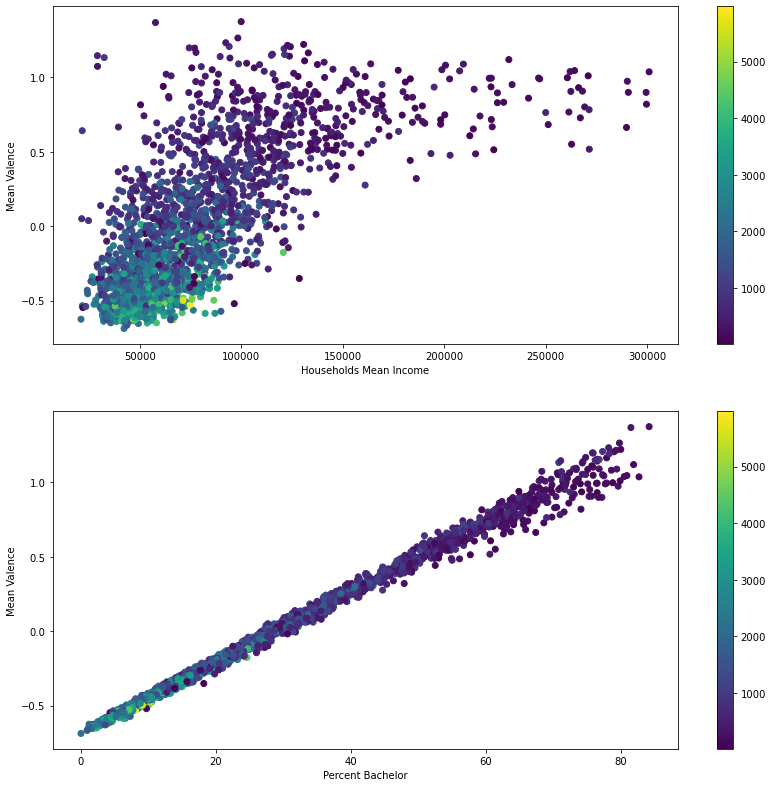

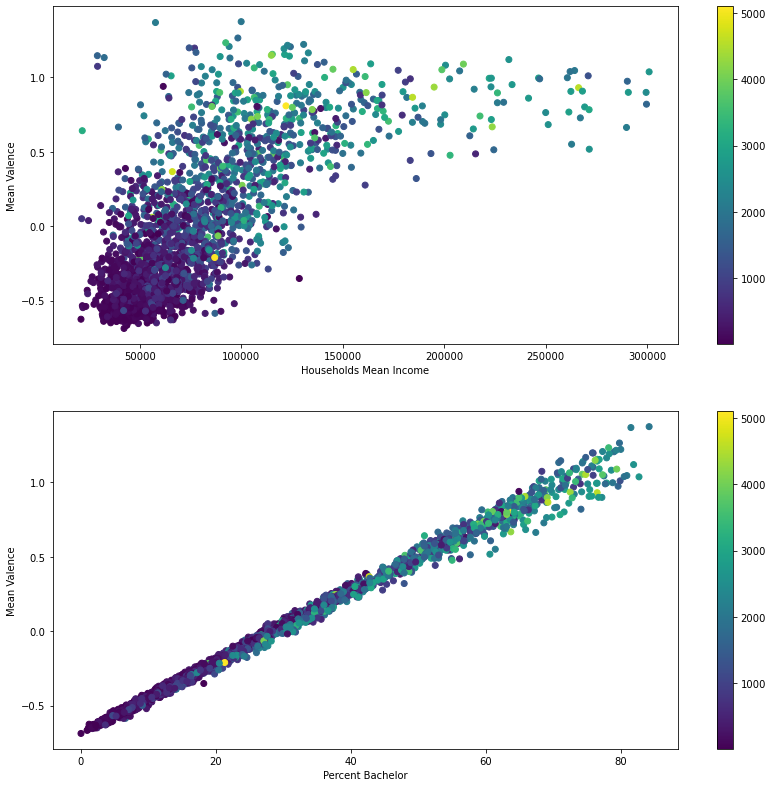

In [961]:
col = np.where(regions['totalGroup1'] < regions['totalGroup2'],'b', 'r')
regions['category'] = col

# Dataframe for separate correlations 
frame = {"category": col, "income": regions['households_meanIncome'], "bachelor": regions['percent_bachelorPlus'], "predictions": predictions }
df = pd.DataFrame(frame)

fig = plt.figure(figsize=(14,5.5))
fig.subplots_adjust(top=2)
ax1 = fig.add_subplot(211)

# Scatter plot and correlation of predicted valences and mean household incomes
plot1 = ax1.scatter(regions['households_meanIncome'], predictions, c=regions['totalGroup1'])
plt.colorbar(plot1, ax=ax1)
ax1.set_xlabel('Households Mean Income')
ax1.set_ylabel('Mean Valence')
print("Correlation grouped by which group an area had more people of:")
print(df.groupby('category')[['income','predictions']].corr().iloc[0::2,-1])

ax2 = fig.add_subplot(212)

# Scatter plot and correlation of predicted valences and number of those with at least a bachelor's
# It can be seen predicted valence is again much lower than ground truth valence and mainly below 5.8 for group 1, despite the model being race blind
plot2 = ax2.scatter(regions['percent_bachelorPlus'], predictions, c=regions['totalGroup1'])
plt.colorbar(plot2, ax=ax2)
ax2.set_xlabel('Percent Bachelor')
ax2.set_ylabel('Mean Valence')

fig2 = plt.figure(figsize=(14,5.5))
fig2.subplots_adjust(top=2)

ax3 = fig2.add_subplot(211)

# Scatter plot and correlation of ground truth valence vs mean household income 
plot3 = ax3.scatter(regions['households_meanIncome'], predictions, c=regions['totalGroup2'])
plt.colorbar(plot3, ax=ax3)
ax3.set_xlabel('Households Mean Income')
ax3.set_ylabel('Mean Valence')

ax4 = fig2.add_subplot(212)

# Scatter plot and correlation of ground truth valence vs mean household income 
plot4 = ax4.scatter(regions['percent_bachelorPlus'], predictions, c=regions['totalGroup2'])
plt.colorbar(plot4, ax=ax4)
ax4.set_xlabel('Percent Bachelor')
ax4.set_ylabel('Mean Valence')

print('\n', df.groupby('category')[['bachelor','predictions']].corr().iloc[0::2,-1], '\n')
print('Overall correlation:\n', df.corr().iloc[0::1,-1])

In [962]:
regions = regions.drop(["category"], axis=1)

In [963]:
import numpy as np
import pandas as pd
import scipy

# Functions in order to generate a target column independent of the inputted protected columns
def gen_latent_fast(df0, prot_col, tar_col):
    """
    generate a representation for target column which is independent from
    any columns in prot_col
    df0: a data frame
    prot_col: list of strings, the protected columns
    tar_col: string, the target (outcome) column
    """
    df = df0.copy()
    for column in df.columns:
        df[column] = df[column] - df[column].mean()
    df_protect = df[prot_col]
    dfv_protect = df_protect.values
    dfv_target = df[tar_col].values
    base_protect = scipy.linalg.orth(dfv_protect)
    for i in range(base_protect.shape[1]):
        #print(base_protect[:,i].shape)
        dfv_target = dfv_target - np.inner(dfv_target, base_protect[:,i])*base_protect[:,i]
    return dfv_target

def gen_latent_nonparam_regula(df0, prot_col, tar_col, lbd):
    """
    generate a fair representation at a certain level define by lbd
    df0: a data frame
    prot_col: list of strings, the protected columns
    tar_col: string, the target (outcome) column
    lbd: float number between 0 and 1, 0 means totally fair; 1 means same as outcome
    """

    dfv_target = df0[tar_col].values
    dfv_mean = df0[tar_col].mean()
    dfv_target = dfv_target - dfv_mean

    latent0 = gen_latent_fast(df0, prot_col, tar_col)

    return latent0 + lbd*(dfv_target - latent0)


In [964]:
# Obtain debiased data and add it to regional data
debiased_values = gen_latent_nonparam_regula(regions, ['totalGroup1', 'totalGroup2'], 'meanvalence', 0)
regions['debiased_values'] = debiased_values

In [965]:
# Again train a new linear model
train_set, test_set = train_test_split(regions, test_size=0.2, random_state=42)
regions_train_copy = train_set.copy()

In [966]:
# Set new variables for testing instead of original valence
regions_train_copy = regions_train_copy.drop(["meanvalence", "debiased_values"], axis=1)
regions_labels = train_set["debiased_values"].copy()
regions_test_y = test_set["debiased_values"].copy()

In [967]:
# Scale down your data
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

regions_prepared = num_pipeline.fit_transform(regions_train_copy)

In [968]:
# Fit the model 
lin_reg = LinearRegression()
lin_reg.fit(regions_prepared, regions_labels)

LinearRegression()

In [969]:
# Check predictions of some values
all_data_prepared = num_pipeline.transform(regions.drop(['meanvalence', 'debiased_values'], axis=1))
predictions = lin_reg.predict(all_data_prepared)

print("Predictions:", predictions)

print("Labels:", regions['debiased_values'])

Predictions: [-0.06437359 -0.0710477  -0.03497352 ...  0.0843148  -0.02116474
 -0.06210504]
Labels: 0      -0.005576
1       0.072522
2      -0.209317
3      -0.178798
4      -0.224059
          ...   
2105   -0.014614
2106   -0.017479
2107   -0.135213
2108   -0.028943
2109   -0.044289
Name: debiased_values, Length: 2097, dtype: float64


Correlation grouped by which group an area had more people of:
category        
b         income    0.259529
r         income    0.300930
Name: predictions, dtype: float64

 category          
b         bachelor    0.819760
r         bachelor    0.492799
Name: predictions, dtype: float64 

Overall correlation:
 income         0.311213
bachelor       0.545115
predictions    1.000000
Name: predictions, dtype: float64


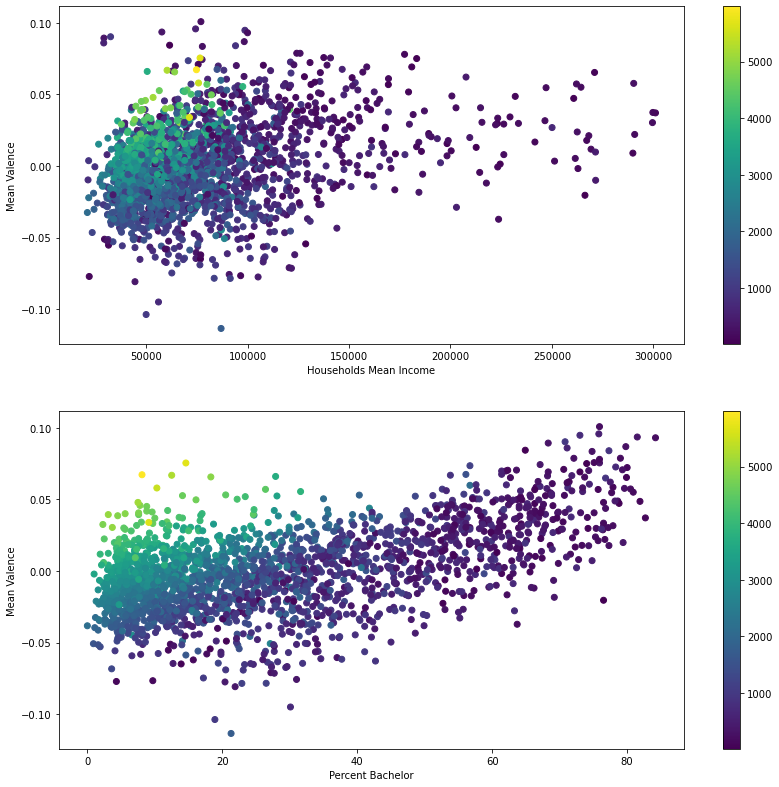

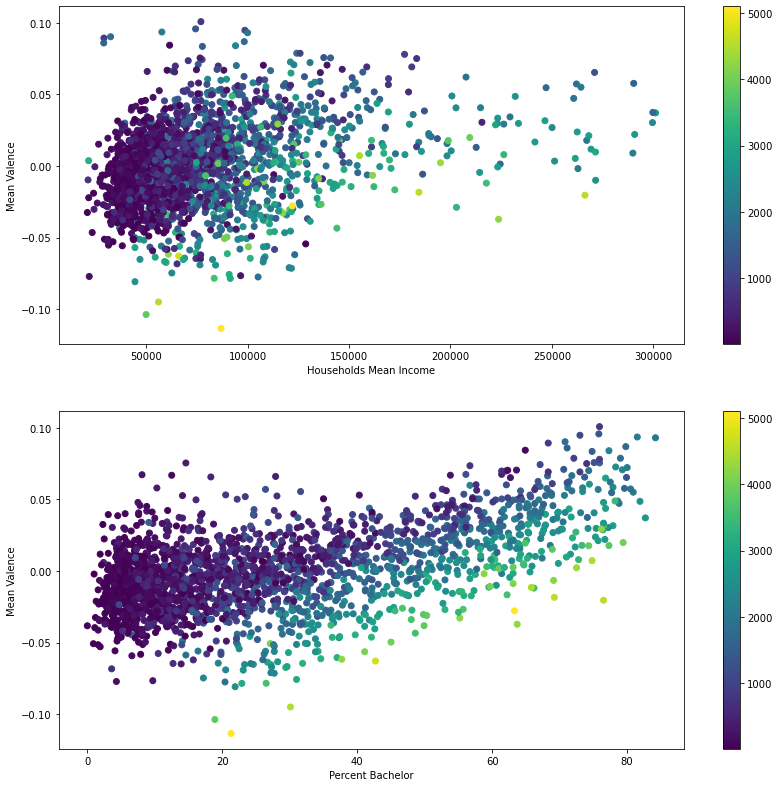

In [970]:
col = np.where(regions['totalGroup1'] < regions['totalGroup2'],'b', 'r')
regions['category'] = col

# Dataframe to separate out correlations 
frame = {"category": col, "income": regions['households_meanIncome'], "bachelor": regions['percent_bachelorPlus'], "predictions": predictions }
df = pd.DataFrame(frame)

fig = plt.figure(figsize=(14,5.5))
fig.subplots_adjust(top=2)
ax1 = fig.add_subplot(211)

# Scatter plot and correlation of predicted debiased valences and mean household incomes
plot1 = ax1.scatter(regions['households_meanIncome'], predictions, c=regions['totalGroup1'])
plt.colorbar(plot1, ax=ax1)
ax1.set_xlabel('Households Mean Income')
ax1.set_ylabel('Mean Valence')
print("Correlation grouped by which group an area had more people of:")
print(df.groupby('category')[['income','predictions']].corr().iloc[0::2,-1])

ax2 = fig.add_subplot(212)

# Scatter plot and correlation of predicted debiased valences and number of those with at least a bachelor's
# It can be seen that these values are far closer to the ground truth valences than the previous two models
plot2 = ax2.scatter(regions['percent_bachelorPlus'], predictions, c=regions['totalGroup1'])
plt.colorbar(plot2, ax=ax2)
ax2.set_xlabel('Percent Bachelor')
ax2.set_ylabel('Mean Valence')

fig2 = plt.figure(figsize=(14,5.5))
fig2.subplots_adjust(top=2)

ax3 = fig2.add_subplot(211)

# Scatter plot and correlation of ground truth valence vs mean household income 
plot3 = ax3.scatter(regions['households_meanIncome'], predictions, c=regions['totalGroup2'])
plt.colorbar(plot3, ax=ax3)
ax3.set_xlabel('Households Mean Income')
ax3.set_ylabel('Mean Valence')

ax4 = fig2.add_subplot(212)

# Scatter plot and correlation of ground truth valence vs mean household income 
plot4 = ax4.scatter(regions['percent_bachelorPlus'], predictions, c=regions['totalGroup2'])
plt.colorbar(plot4, ax=ax4)
ax4.set_xlabel('Percent Bachelor')
ax4.set_ylabel('Mean Valence')

print('\n',df.groupby('category')[['bachelor','predictions']].corr().iloc[0::2,-1], '\n')
print('Overall correlation:\n', df.corr().iloc[0::1,-1])